In [1]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from django.db.models import Count, Avg, F
import difflib


sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
p = Project.objects.get(title="NETs")

In [2]:
# Quick hack to relevantise innovation docs
qs = Query.objects.filter(pk__in=[2359,2366,2372])
nqdoc_ids = list(Doc.objects.filter(query__in=qs).values_list('id',flat=True))
dos =  DocOwnership.objects.filter(query__in=qs,relevant=1)
nem=User.objects.get(username="nemet")

for t in Technology.objects.filter(project=p):
    for i in Innovation.objects.filter(project=p):
        if t.name=="Biochar":
            t = Technology.objects.get(name="Soil Carbon Sequestration")
        if t.name=="Ocean Alkalinisation":
            t = Technology.objects.get(name="Ocean fertilisation")
        if t.name=="Enhanced Weathering":
            t = Technology.objects.get(name="Ocean fertilisation")
            
        nq, created = Query.objects.get_or_create(
            project=p,
            title="Relevant new docs_{}_{}".format(t,i),
            text="[Auto generated]",
            creator=User.objects.get(username="galm")             
        )
        if t.name=="NETS - General":
            nq.delete()
            continue
        
        nq.innovation=i
        nq.technology=t
        tqdocs = Doc.objects.filter(
            id__in=list(set(nqdoc_ids)),
            docownership__query__technology=t,
            docownership__relevant=1,
            innovation=i
        )
        for d in tqdocs:
            d.query.add(nq)
            do, created = DocOwnership.objects.get_or_create(
                user=nem,
                query=nq,
                doc=d,
                relevant=5
            )
            do.save()
            d.save()
        nq.r_count = tqdocs.count()
        nq.save()

#for do in dos:
#    do.relevant=5
#    do.save()
    
    




In [3]:
p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p) | Doc.objects.filter(technology__project=p)

trdocs = set(list(pdocs.filter(docownership__relevant=1).values_list('id',flat=True)))

irdocs = set(list(pdocs.filter(docownership__relevant=5).values_list('id',flat=True)))

inrateddocs = set(list(pdocs.filter(docownership__relevant__in=[5,6,7,8]).values_list('id',flat=True)))


In [4]:
print(len(trdocs))
print(len(irdocs))
print(len(inrateddocs))

print(len(trdocs.intersection(inrateddocs)))

alltdocs = pdocs.distinct().filter(
    id__in=trdocs
)

allreldocs = pdocs.distinct().filter(
    id__in=trdocs.intersection(irdocs)
)

alliratdocs = pdocs.distinct().filter(
    id__in=trdocs.intersection(inrateddocs)
)

print(allreldocs.count())

2728
1912
2515
1026
808


In [5]:
print(alliratdocs.count())

dos_g = DocOwnership.objects.filter(doc__in=alliratdocs,user__username="nemet",relevant__gt=0).order_by('query','doc')
dos_s = DocOwnership.objects.filter(doc__in=alliratdocs,user__username="rogers",relevant__gt=0).order_by('query','doc')

print(dos_g.count())

print(dos_s.count())

gscores = []
sscores = []

agrees = 0
disagrees = 0

for s in dos_s:
    g = dos_g.filter(query=s.query,doc=s.doc)
    if g.count() > 0:
        if g.count() > 1:
            print(g.count())
        g = g.first().relevant
    else:
        continue
        g = None
    gscores.append(g)
    sscores.append(s.relevant)
    if g == s.relevant:
        agrees+=1
    else:
        disagrees+=1



agreement = round(difflib.SequenceMatcher(None,gscores,sscores).ratio(),2)

agreement


1026
2165
936


0.01

In [6]:
print(agrees)
print(disagrees)

756
176


In [7]:
difflib.SequenceMatcher(None,gscores[0:250],sscores[0:250]).ratio()

0.032

In [8]:
difflib.SequenceMatcher(None,[1,2,3],[1,2]).ratio()

0.8

In [9]:
len(gscores)
len(sscores)

932

In [10]:
allidocs = allreldocs.filter(
    docownership__relevant=5,
).values('PY','docownership__query__innovation__name').annotate(
    n = Count('pk', distinct = True)
)
df = pd.DataFrame.from_dict(list(allidocs))
df.head()

,PY,docownership__query__innovation__name,n
0,2012,Scaleup,20
1,2008,RD,32
2,2006,Scaleup,6
3,2017,RD,49
4,2004,RD,11


     PY docownership__query__innovation__name    n
0  1990                            Demandpull  0.0
1  1990                                 Demos  0.0
2  1990                          Nichemarkets  0.0
3  1990                          Publicaccept  0.0
4  1990                                    RD  0.0
       PY docownership__query__innovation__name     n
70   2001                                    RD  10.0
136  2012                                    RD  59.0
82   2003                                    RD   9.0
130  2011                                    RD  43.0
166  2017                                    RD  49.0


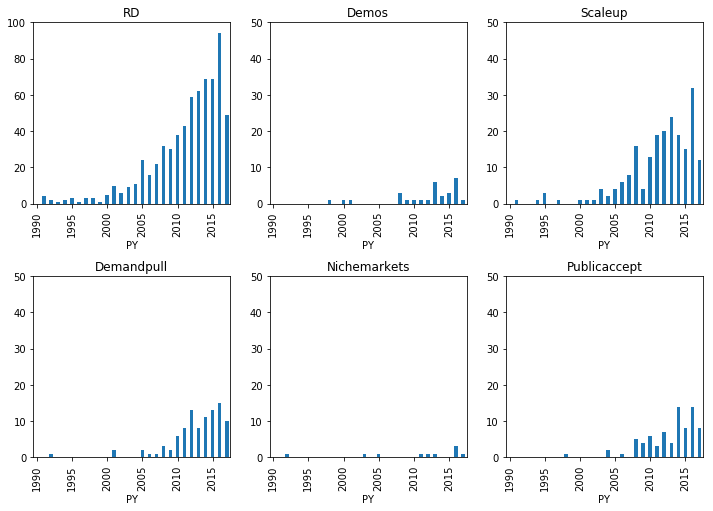

In [11]:
plt.rcParams["figure.figsize"] = [12,8]

fig, axs = plt.subplots(nrows=2,ncols=3,gridspec_kw=dict(hspace=0.4))

pt = pd.pivot_table(
    df,
    values='n',
    columns=['PY'],
    index=['docownership__query__innovation__name'],
    fill_value=0
)

fullindex = pd.DatetimeIndex(freq='1A', start='1974', end='2017')

pt = (
    df.set_index(['PY','docownership__query__innovation__name'])
        .unstack(level='docownership__query__innovation__name')
        .reindex(range(1990,2018))
        .fillna(0)
        .stack()
        .reset_index()
)

print(pt.head())

iorder =[
    "RD",
    "Demos",
    "Scaleup",
    "Demandpull",                                                             
    "Nichemarkets",
    "Publicaccept"
]


pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],iorder)

pt = pt.sort_values(['docownership__query__innovation__name'])

print(pt.head())


grouped =  pt.groupby('docownership__query__innovation__name')

#grouped = grouped.sort_values('docownership__query__innovation__name')

targets = zip(iorder, axs.flatten())

n = 5

for i, (key, ax) in enumerate(targets):
    
    group = grouped.get_group(key)
    
    group = group.sort_values('PY')
    group = group.set_index('PY')
    group.plot.bar(ax=ax, legend=False)
    #ax.bar(group.index,group['n'])
    #ax.bar(group,group[['n']])
    
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::n])
    ax.xaxis.set_ticklabels(ticklabels[::n])
    
    if key=="RD":   
        m = 100
    else:   
        m = 50
        
    ax.set_ylim(0,m)
    
    
    ax.set_title(key)
    
    s = "N = {:d}".format(int(group.sum()['n']))
    
    #ax.text(1,m*0.8, s)
    

plt.savefig('plots/1_1_1.png',bbox_inches='tight') 
plt.savefig('plots/1_1_1.svg',bbox_inches='tight') 
plt.show()

In [12]:
allds = allreldocs.filter(
    docownership__relevant__in=[5,1],
).values(
    'docownership__query__innovation__name',
    'docownership__query__technology__name',
    'PY'
).annotate(
    n = Count('pk', distinct = True)
)
lallds = list(allds)
lallds.append({
    "PY":1990,
    "docownership__query__innovation__name": "Scaleup",
    "docownership__query__technology__name": "Afforestation/reforestation",
    "n": 0
})
adf = pd.DataFrame.from_dict(lallds)
adf = adf[adf['docownership__query__innovation__name'] != "None"]
adf.sort_values('PY').head()

,PY,docownership__query__innovation__name,docownership__query__technology__name,n
373,0,None,BECCS,2
67,0,RD,Bioenergy,2
149,0,None,DACCS,3
69,0,RD,DACCS,3
72,0,Demandpull,DACCS,2


In [13]:
reindexes = [
    ('PY','docownership__query__technology__name','docownership__query__innovation__name'),
    ('PY','docownership__query__innovation__name','docownership__query__technology__name'),
    ('docownership__query__innovation__name','docownership__query__technology__name','PY')
]

pt = adf

pt = pt[pt['docownership__query__technology__name']!="Blue Carbon"]
pt = pt[pt['docownership__query__technology__name']!="Geological Storage"]
pt = pt[pt['docownership__query__technology__name']!="Ethics & Morals"]
pt = pt[pt['docownership__query__technology__name']!="Bioenergy"]
pt = pt[pt['docownership__query__technology__name']!="NETs - General"]

for x in reindexes:

    pt = pd.pivot_table(
        pt,
        values='n',
        columns=[x[2]],
        index=[x[0],x[1]],
        fill_value=0
    ).reset_index()


    pt = pd.melt(
        pt,
        id_vars=[x[0],x[1]],
        value_name='n'
    ).reset_index()

pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],
                                                            [
                                                                "RD",
                                                                "Scaleup",
                                                                "Demandpull",
                                                                "Publicaccept",
                                                                "Demos",
                                                                "Nichemarkets"
                                                            ])

pt = pt.sort_values(['PY','docownership__query__innovation__name'])


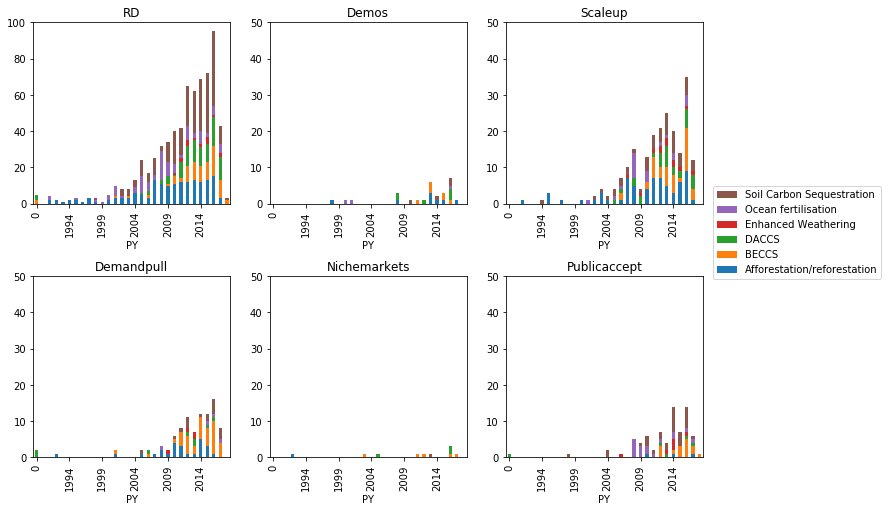

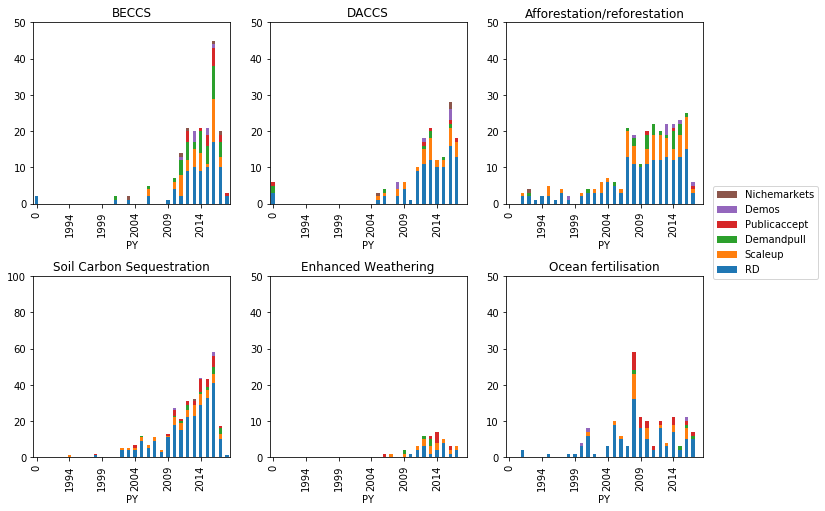

In [14]:
groupings = [
    ('docownership__query__innovation__name','docownership__query__technology__name',2),
    ('docownership__query__technology__name','docownership__query__innovation__name',2),
]


for x in groupings:
    
    plt.rcParams["figure.figsize"] = [12,4*x[2]]
    
    grouped = pt.groupby(x[0])

    fig, axs = plt.subplots(nrows=x[2],ncols=3,gridspec_kw=dict(hspace=0.4))
    targets = zip(grouped.groups.keys(), axs.flatten())
    
    if x[0]=='docownership__query__innovation__name':
        targets = zip(iorder, axs.flatten())

    for i, (key, ax) in enumerate(targets):
        try:
            group = grouped.get_group(key)
            group = group.sort_values('PY')

            table = pd.pivot_table(
                group,
                values='n',
                columns=[x[1]],
                index=['PY']
            )

            table.plot.bar(ax=ax,stacked=True,legend=False,title=key)
            
            #l = ax.legend()

            if i == 0:
                #ax.legend()
                handles, labels = ax.get_legend_handles_labels()
            
            ticks = ax.xaxis.get_ticklocs()
            ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
            ax.xaxis.set_ticks(ticks[::n])
            ax.xaxis.set_ticklabels(ticklabels[::n])
            
            if key in ["RD","Soil Carbon Sequestration"]:   
                m = 100
            else:   
                m = 50
        
            ax.set_ylim(0,m)
            
            
        except:
            print(key)
            print(group)
            pass

    #plt.legend()
    #ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    #fig.subplots_adjust(right=0.65)
    if x[2]==3:
        lpos = (1.1,0.75)
        axs[-1,-1].axis('off')
        axs[-1,-2].axis('off')
    else:
        lpos = (1.05,1.5)
    ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)
    plt.savefig('plots/1_1_{}.png'.format(x[2]),bbox_inches='tight') 
    plt.show()

In [15]:
etechs = ["Ethics & Morals","Geological Storage","Bioenergy","Blue Carbon"]

tdocs = allreldocs.filter(
    docownership__relevant=1,
    docownership__query__technology__name__isnull=False,
).exclude(
    docownership__query__technology__name__in=etechs
).values(
    'docownership__query__technology__name',
    'id',
    'PY'
)
techdocs = pd.DataFrame.from_dict(list(tdocs))


In [16]:
idocs = allreldocs.filter(
    docownership__relevant=5
).values(
    'docownership__query__innovation__name',
    'id',
    'PY'
)
indocs = pd.DataFrame.from_dict(list(idocs))


In [17]:
irdocs = alliratdocs.filter(

).values(
    'docownership__query__innovation__name',
    'id',
    'PY'
)
irdocs = pd.DataFrame.from_dict(list(irdocs))

irdocs = irdocs[irdocs['docownership__query__innovation__name'] != "Innovationgeneral"]

print(len(irdocs))

print(len(irdocs.drop_duplicates()))

print(irdocs.head())


2911
2911
     PY docownership__query__innovation__name      id
0  2015                          Publicaccept  471463
1  2011                            Demandpull  220130
2  2012                          Publicaccept  571964
3  2015                                  None  555599
4  2017                                    RD  757700


In [18]:
alldocs = techdocs.merge(indocs,how="outer")
allrateddocs = techdocs.merge(irdocs, how="outer")

print(len(alldocs))

print(len(allrateddocs))




alldocs.sort_values('id').head()

1265
3203


,PY,docownership__query__technology__name,id,docownership__query__innovation__name
824,2008,Ocean fertilisation,2366,RD
825,2008,Ocean fertilisation,2366,Demandpull
0,2016,Afforestation/reforestation,3813,Scaleup
1,2016,Afforestation/reforestation,3813,RD
574,2012,DACCS,3814,RD


In [19]:
allrateddocs.head()

,PY,docownership__query__technology__name,id,docownership__query__innovation__name
0,2016,Afforestation/reforestation,3813,RD
1,2016,Afforestation/reforestation,3813,Publicaccept
2,2016,Afforestation/reforestation,3813,Scaleup
3,2016,Afforestation/reforestation,3813,None
4,2007,Afforestation/reforestation,12897,RD


In [20]:
def fix_table(df):
    table = df.groupby(['docownership__query__technology__name','docownership__query__innovation__name'])
    table = table.count()
    table = table.reset_index()
    table = table.rename(columns={'id':'n'})
    table = table.drop('PY',1)

    table = pd.pivot_table(
            table,
            values='n',
            index=['docownership__query__technology__name'],
            columns=['docownership__query__innovation__name'],
            fill_value=0
        ).reset_index()

    #table.index.rename('index',True)
    print(table.columns)
    
    table.columns = ['Technology','Demandpull','Demos','Nichemarkets','Publicaccept','RD','Scaleup']

    table = table[['Technology','RD','Demos','Scaleup','Demandpull','Nichemarkets','Publicaccept']]

    table['Total'] = table.sum(axis=1,numeric_only=True)
    return(table)
    
table = fix_table(alldocs)

basic_table = table

allratedtable = fix_table(allrateddocs)

def get_ttotal(i):
    x = allreldocs.filter(
        docownership__query__technology__name=i['Technology'],
        docownership__relevant=1
    ).distinct().count()
    if x == 0:
        x = np.NaN
    return(x)

def get_itotal(i):
    x = allreldocs.filter(
        docownership__query__innovation__name=i.name,
        docownership__relevant=5
    ).distinct().count()
    if x == 0:
        x = np.NaN
    return(x)

def get_irattotal(i):
    x = alliratdocs.filter(
        docownership__query__technology__name=i['Technology']
    ).distinct().count()
    if x == 0:
        x = np.NaN
    return(x)

def get_ttotal_all(i):
    x = alltdocs.filter(
        docownership__query__technology__name=i['Technology'],
        docownership__relevant=1
    ).distinct().count()
    return(x)

table['distinct_Total'] = table.apply(lambda x: get_ttotal(x), axis=1)

table['distinct_anyrating_Total'] = table.apply(lambda x: get_irattotal(x), axis=1)

table['distinct_alltech_Total'] = table.apply(lambda x: get_ttotal_all(x), axis=1)

table.set_index('Technology',inplace=True)

table.loc['Total'] = table.sum()

table.loc['distinct_Total'] = table.apply(lambda x: get_itotal(x))


table.head(15)

#table.sum(axis=0,numeric_only=True)

Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')
Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total,distinct_Total,distinct_anyrating_Total,distinct_alltech_Total
Technology,,,,,,,,,,
Afforestation/reforestation,148.0,9.0,62.0,24.0,1.0,7.0,251.0,196.0,276.0,485.0
BECCS,60.0,7.0,36.0,31.0,5.0,10.0,149.0,105.0,148.0,242.0
Biochar,52.0,1.0,15.0,4.0,1.0,5.0,78.0,62.0,81.0,108.0
DACCS,92.0,7.0,29.0,8.0,2.0,5.0,143.0,107.0,152.0,250.0
Enhanced Weathering,13.0,1.0,7.0,1.0,0.0,5.0,27.0,19.0,38.0,35.0
NETs - General,53.0,6.0,29.0,21.0,5.0,9.0,123.0,75.0,100.0,258.0
Ocean Alkalinisation,5.0,0.0,6.0,2.0,0.0,2.0,15.0,10.0,17.0,20.0
Ocean fertilisation,90.0,4.0,22.0,5.0,0.0,14.0,135.0,98.0,110.0,216.0
Soil Carbon Sequestration,183.0,4.0,37.0,11.0,0.0,22.0,257.0,209.0,394.0,452.0


In [21]:
ttable = allratedtable

ttable.head()

,Technology,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
0,Afforestation/reforestation,148,13,79,42,3,85,370
1,BECCS,60,17,56,56,5,43,237
2,Biochar,52,9,23,10,1,25,120
3,DACCS,92,24,41,15,3,20,195
4,Enhanced Weathering,13,2,9,1,0,8,33


In [22]:
rtable = table

rtable = rtable.drop(['Total','distinct_Total','distinct_anyrating_Total'],1)

for col in rtable.columns:

    rtable[col] = rtable[col]/rtable['distinct_alltech_Total']*100
    


rtable.head()

,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,distinct_alltech_Total
Technology,,,,,,,
Afforestation/reforestation,30.515464,1.855670,12.783505,4.948454,0.206186,1.443299,100.0
BECCS,24.793388,2.892562,14.876033,12.809917,2.066116,4.132231,100.0
Biochar,48.148148,0.925926,13.888889,3.703704,0.925926,4.629630,100.0
DACCS,36.800000,2.800000,11.600000,3.200000,0.800000,2.000000,100.0
Enhanced Weathering,37.142857,2.857143,20.000000,2.857143,0.000000,14.285714,100.0


In [23]:
basic_table = fix_table(alldocs)
basic_table = basic_table.set_index('Technology')

basic_table.head()

Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
Technology,,,,,,,
Afforestation/reforestation,148,9,62,24,1,7,251
BECCS,60,7,36,31,5,10,149
Biochar,52,1,15,4,1,5,78
DACCS,92,7,29,8,2,5,143
Enhanced Weathering,13,1,7,1,0,5,27


In [24]:
allratedtable = fix_table(allrateddocs).set_index('Technology')
allratedtable.head()

Index(['docownership__query__technology__name', 'Demandpull', 'Demos',
       'Nichemarkets', 'Publicaccept', 'RD', 'Scaleup'],
      dtype='object', name='docownership__query__innovation__name')


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
Technology,,,,,,,
Afforestation/reforestation,148,13,79,42,3,85,370
BECCS,60,17,56,56,5,43,237
Biochar,52,9,23,10,1,25,120
DACCS,92,24,41,15,3,20,195
Enhanced Weathering,13,2,9,1,0,8,33


In [25]:
rtable2 = basic_table/allratedtable*100
rtable2 = rtable2.fillna(0)
rtable2

,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept,Total
Technology,,,,,,,
Afforestation/reforestation,100.0,69.230769,78.481013,57.142857,33.333333,8.235294,67.837838
BECCS,100.0,41.176471,64.285714,55.357143,100.000000,23.255814,62.869198
Biochar,100.0,11.111111,65.217391,40.000000,100.000000,20.000000,65.000000
DACCS,100.0,29.166667,70.731707,53.333333,66.666667,25.000000,73.333333
Enhanced Weathering,100.0,50.000000,77.777778,100.000000,0.000000,62.500000,81.818182
NETs - General,100.0,60.000000,76.315789,67.741935,100.000000,39.130435,76.875000
Ocean Alkalinisation,100.0,0.000000,100.000000,100.000000,0.000000,33.333333,78.947368
Ocean fertilisation,100.0,57.142857,61.111111,50.000000,0.000000,56.000000,79.881657
Soil Carbon Sequestration,100.0,30.769231,64.912281,57.894737,0.000000,15.277778,61.336516


In [26]:
itable = table

itable = itable.drop(['Total','distinct_Total','distinct_alltech_Total','distinct_anyrating_Total'],1)

for col in itable.columns:

    itable[col] = itable[col]/itable['RD']*100
    


itable.head()


,RD,Demos,Scaleup,Demandpull,Nichemarkets,Publicaccept
Technology,,,,,,
Afforestation/reforestation,100.0,9.0,62.0,24.0,1.0,7.0
BECCS,100.0,7.0,36.0,31.0,5.0,10.0
Biochar,100.0,1.0,15.0,4.0,1.0,5.0
DACCS,100.0,7.0,29.0,8.0,2.0,5.0
Enhanced Weathering,100.0,1.0,7.0,1.0,0.0,5.0


In [27]:
writer = pd.ExcelWriter('tables/tech_innov_totals.xlsx')
table.to_excel(writer,'Relevant Documents')
rtable.to_excel(writer,'% Relevant of Technology')
rtable2.to_excel(writer,'% Relevant of Technology rated')
itable.to_excel(writer, '% Stage')
ttable.to_excel(writer,'Any Rating Totals')
writer.save()

In [28]:
alldocs = alldocs[alldocs['docownership__query__technology__name']!="Blue Carbon"]
alldocs = alldocs[alldocs['docownership__query__technology__name']!="Geological Storage"]

byyear = alldocs.groupby(['PY','docownership__query__technology__name','docownership__query__innovation__name'])
byyear = byyear.count()
byyear = byyear.reset_index()
byyear = byyear.fillna(0)
byyear = byyear.rename(columns={'id':'n'})


byyear.head()

,PY,docownership__query__technology__name,docownership__query__innovation__name,n
0,0,BECCS,RD,1
1,0,DACCS,Demandpull,2
2,0,DACCS,Publicaccept,1
3,0,DACCS,RD,3
4,0,NETs - General,Demandpull,1


In [29]:
### Prepare Byyears, extend indexes
reindexes = [
    ('PY','docownership__query__technology__name','docownership__query__innovation__name'),
    ('PY','docownership__query__innovation__name','docownership__query__technology__name'),
    ('docownership__query__innovation__name','docownership__query__technology__name','PY')
]

pt = byyear


pt = pt[pt['docownership__query__technology__name']!="Blue Carbon"]
pt = pt[pt['docownership__query__technology__name']!="Geological Storage"]

for x in reindexes:

    pt = pd.pivot_table(
        pt,
        values='n',
        columns=[x[2]],
        index=[x[0],x[1]],
        fill_value=0
    ).reset_index()


    pt = pd.melt(
        pt,
        id_vars=[x[0],x[1]],
        value_name='n'
    ).reset_index()

pt['docownership__query__innovation__name'] = pd.Categorical(pt['docownership__query__innovation__name'],
                                                            [
                                                                "RD",
                                                                "Demos",
                                                                "Scaleup",
                                                                "Demandpull",                                                             
                                                                "Nichemarkets",
                                                                "Publicaccept"
                                                            ])

pt = pt.sort_values(['PY','docownership__query__innovation__name'])

In [30]:
pt = pt[pt['docownership__query__technology__name']!="Blue Carbon"]
pt = pt[pt['docownership__query__technology__name']!="Geological Storage"]
pt = pt[pt['docownership__query__technology__name']!="Ocean Alkalinisation"]

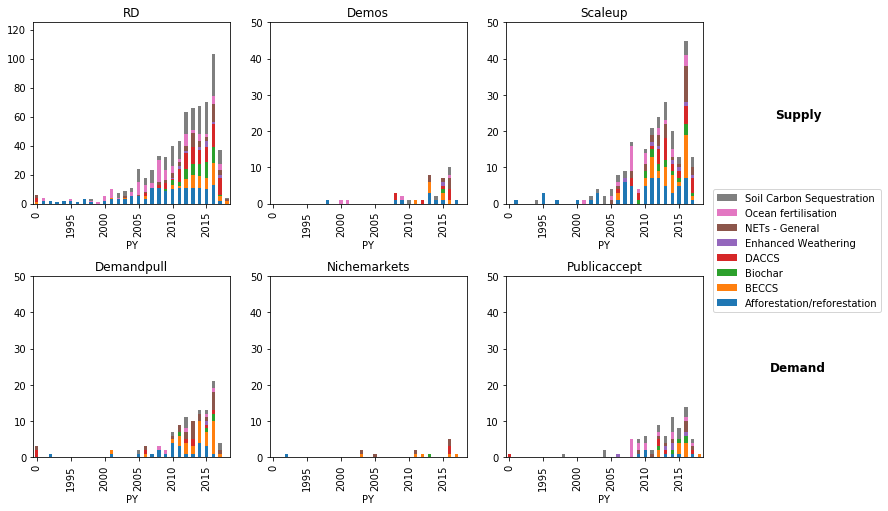

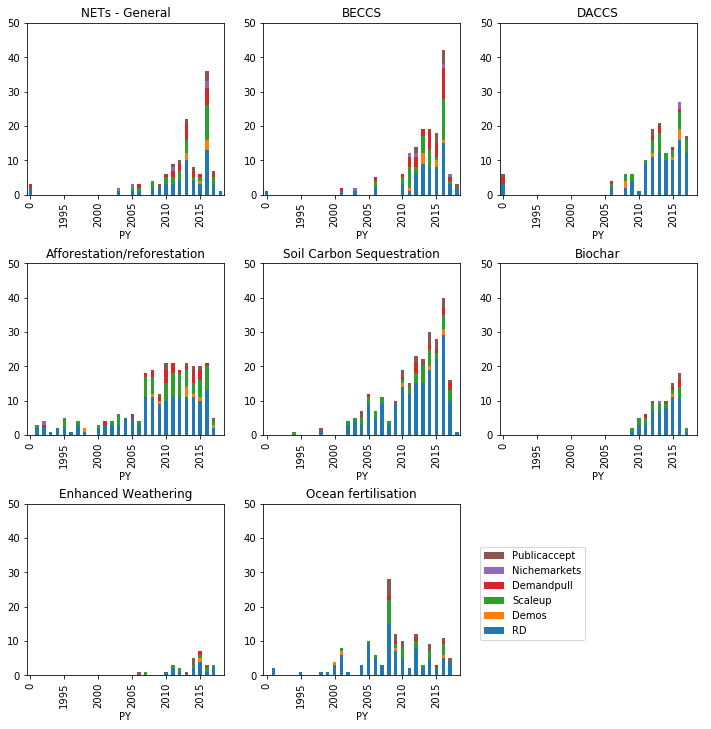

In [31]:
groupings = [
    ('docownership__query__innovation__name','docownership__query__technology__name',2),
    ('docownership__query__technology__name','docownership__query__innovation__name',3),
]


for x in groupings:
    
    plt.rcParams["figure.figsize"] = [12,4*x[2]]
    
    grouped = pt.groupby(x[0])

    fig, axs = plt.subplots(nrows=x[2],ncols=3,gridspec_kw=dict(hspace=0.4))
    targets = zip(grouped.groups.keys(), axs.flatten())
    
    if x[2]==2:
        targets = zip(iorder, axs.flatten())
        

    for i, (key, ax) in enumerate(targets):
        try:
            group = grouped.get_group(key)
            group = group.sort_values('PY')

            table = pd.pivot_table(
                group,
                values='n',
                columns=[x[1]],
                index=['PY']
            )

            table.plot.bar(ax=ax,stacked=True,legend=False,title=key, sort_columns=True)
            
            #l = ax.legend()

            if i == 0:
                #ax.legend()
                handles, labels = ax.get_legend_handles_labels()
            
            ticks = ax.xaxis.get_ticklocs()
            ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
            ax.xaxis.set_ticks(ticks[::n])
            ax.xaxis.set_ticklabels(ticklabels[::n])
            
            if key=="RD":   
                m = 125
            else:   
                m = 50
        
            ax.set_ylim(0,m)
            
            
        except:
            print(key)
            print(group)
            pass

    #plt.legend()
    #ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
    #fig.subplots_adjust(right=0.65)
    if x[2]==3:
        lpos = (1.1,0.75)
        axs[-1,-1].axis('off')
        #axs[-1,-2].axis('off')
    else:
        lpos = (1.05,1.48)
    ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)
    if x[2]==3:
        f = 3
    else:
        f = 2
        fp = matplotlib.font_manager.FontProperties(weight="demibold", size="large")
        fig.text(1.01,0.72,"Supply",va="center", ha="center", fontproperties=fp)
        fig.text(1.01,0.28,"Demand",va="center", ha="center", fontproperties=fp)
    plt.savefig('plots/1_1_{}.png'.format(f),bbox_inches='tight') 
    plt.savefig('plots/1_1_{}.svg'.format(f),bbox_inches='tight')
    plt.show()